In [2]:
import pickle
import numpy as np
import time

from tqdm import tqdm, trange 
from PIL import Image
from pathlib import Path
from torch.optim import lr_scheduler
from torchvision import models
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import pandas as pd
import torch

import PIL
print("PIL version:", PIL.__version__)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available.  Training on CPU ...")
else:
    print("CUDA is available! Training on GPU ...")

PIL version: 10.2.0
CUDA is available! Training on GPU ...


In [3]:
DATA_MODES = ["train", "val", "test"]
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

# EDA

Для початку, давайте ознайомимося з кількістю екземплярів кожного класу у нашій тренувальній вибірці.

In [4]:
TRAIN_DIR = Path("./train/")
TEST_DIR = Path("./testset")

In [5]:
train_val_files = sorted(list(TRAIN_DIR.rglob("*.jpg")))
test_files = sorted(list(TEST_DIR.rglob("*.jpg")))

print("Кількість зображеь у тренувальній вибірці: ", len(train_val_files))
print("Кількість зображеь у тестовій вибірці: ", len(test_files))

train_val_dirs = list(set([file.parent.name for file in train_val_files]))

simpsons_statistics = dict()
for dir in train_val_dirs[1:]:
    files = sorted(list(Path(f"./train/simpsons_dataset/{dir}/").rglob("*.jpg")))
    simpsons_statistics[dir] = len(files)

simpsons_statistics = pd.DataFrame(list(simpsons_statistics.items()), columns=["Character", "Count"])
simpsons_statistics.head()

Кількість зображеь у тренувальній вибірці:  58934
Кількість зображеь у тестовій вибірці:  991


,Character,Count
0,patty_bouvier,72
1,disco_stu,8
2,krusty_the_clown,1206
3,maggie_simpson,128
4,homer_simpson,2246


D:\Users\PC\AppData\Local\Temp\ipykernel_9304\1433374380.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns_plot.set_xticklabels(


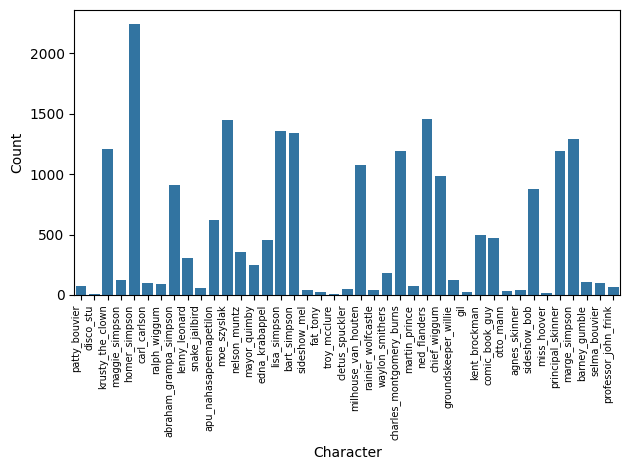

In [6]:
sns_plot = sns.barplot(data=simpsons_statistics, x="Character", y="Count")
sns_plot.set_xticklabels(
    sns_plot.get_xticklabels(), rotation=90, horizontalalignment="right", fontsize=7
)
plt.tight_layout()
plt.show()

#### Підготовка датасету

In [8]:
class SimpsonsDataset():
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != "test":
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open("label_encoder.pkl", "wb") as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode != "train":
            transform = transform_with_no_augm
        else:
            transform = transform_with_augm

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)

        if self.mode == "test":
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [15]:
import os

folders = [
    name
    for name in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, name))
]

train_val_files = sorted(list(TRAIN_DIR.rglob("*.jpg")))
test_files = sorted(list(TEST_DIR.rglob("*.jpg")))

**Висновок щодо розмноження**

В ході розмноження даних я збільшив кількість зображень для всіх класів, що налічували меньше 500 екземплярів. Таким чином ми зможемо добитися кращої якості класифікації нашої моделі.

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(
    train_val_files, test_size=0.3, stratify=train_val_labels
)

print("Кількість зображеь у тренувальній вибірці: ", len(train_files))
print("Кількість зображеь у валідаційній вибірці: ", len(val_files))

val_dataset = SimpsonsDataset(val_files, mode="val")
train_dataset = SimpsonsDataset(train_files, mode="train")

Кількість зображеь у тренувальній вибірці:  41253
Кількість зображеь у валідаційній вибірці:  17681


Тепер виведемо декілька зображень персонажів з тренувальної вибірки, щоб зрозуміти як аугментація відобразилася на даних.

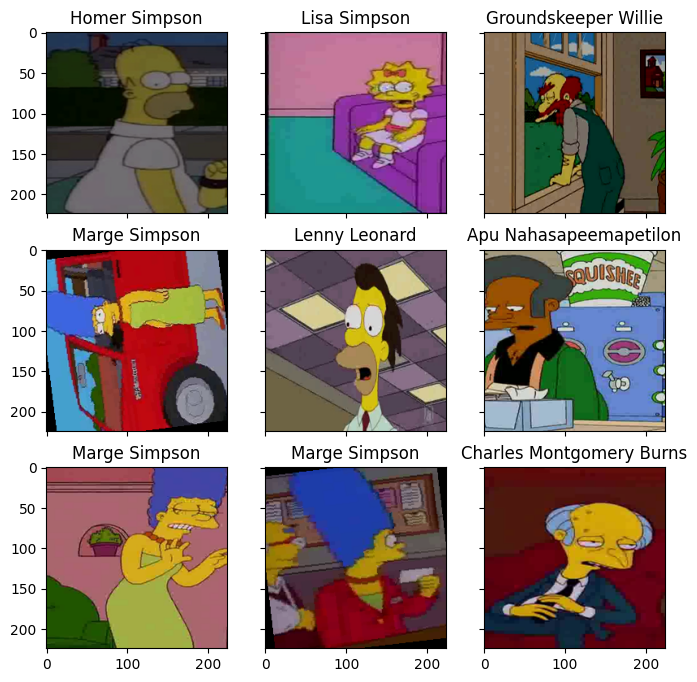

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharex=True, sharey=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 10000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(
        map(
            lambda x: x.capitalize(),
            train_dataset.label_encoder.inverse_transform([label])[0].split("_"),
        )
    )
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

In [32]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for batch in test_loader:
            batch = batch.to(DEVICE)
            model.eval()
            outputs = model(batch).cpu()
            logits.append(outputs)

    preds = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return preds

# ResNet18 Fine-Tuning

Тепер ми реалізуємо fine-tuning моделі ResNet18. 

В даному розділі представлена фінальна версія навчання моделі. Гіперпараметри та дані тут дібрані ттаким чином, щоб найоптимальніше продемонструвати ефективність мережі. 

Особливості навчання:
1. Тренувати модель будемо на нерозмноженому датасеті, для економії часу. В ході декількох експериментів я визначив, що рохмноження та аугментація не впливають на якість моделі суттєво.
2. Fully Connected шар замінюємо лінійним класифікатором (512 to 42).
3. Learning rate буде сталий і заданий як 0.001. Під час експериментів я прийшов до висновку, що sceduler допомагає в тих випадках, коли модель навчається більше 15 епох та коли ми маємо час на навчання. У випадку з ResNet я прийняа рішення відмовитись від StepLR.
4. За оптимізатор був обраний Adam, адже він є загальноприйнятим еталоном.
5. Для навчання за обрав 12 епох. Я золоте правило - не зупиняти процес, поки якість моделі росте, проте через обмежений час я не став продовжувати навчання. 


In [13]:
resnet = models.resnet18(pretrained=True)
resnet

d:\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to D:\Users\PC/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.8MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
num_features = 512
n_classes = len(np.unique(train_val_labels))
resnet.fc = nn.Linear(num_features, n_classes)
resnet = resnet.cuda()

loss_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet.parameters(), lr=0.001)

Більшість досліджень вказує на те, що найкраща техніка зміни lr - це **Step Decay**. Його я використовував в комбінації з оптимізатором **Adam**, що показує зазвичай кращий результат серед більшості альтернатив.
Проте через обмежений час на навчання я був змушений відмовитися від scheduler та задати стало високу швидкість навчання - 0.01.

In [17]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_resnet, step_size=3, gamma=0.1)

Тепер я реалізую модифіковану функцію, що буде її навчати.

In [22]:
def train_model(
    train_dataset, val_dataset, model, criterion, optimizer, scheduler=None, num_epochs=12
):
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_f1 = 0.0  # Variable to store best F1 score
    losses = {"train": [], "val": []}
    f1_scores = {"train": [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")
    for epoch in pbar:
        for phase in ["train", "val"]:
            if phase == "train":
                model.train(True)
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            if phase == "train":
                loader = train_loader
                dataset_size = len(train_dataset)
            else:
                loader = val_loader
                dataset_size = len(val_dataset)

            for data in tqdm(loader, leave=False, desc=f"{phase} iter:"):
                inputs, labels = data

                if train_on_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, -1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects / dataset_size
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')  # Calculate F1 score

            losses[phase].append(epoch_loss)
            f1_scores[phase].append(epoch_f1)

            pbar.set_description(
                "{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_f1)
            )

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
            if phase == "val" and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:.4f}".format(best_acc))
    print("Best val F1: {:.4f}".format(best_f1))

    model.load_state_dict(best_model_wts)
    return model, losses, f1_scores

In [23]:
model, losses, f1 = train_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model=resnet,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optimizer_resnet,
    # scheduler=exp_lr_scheduler,
    num_epochs=12,
)

val Loss: 0.0014 Acc: 0.9898 F1: 0.9918: 100%|██████████| 12/12 [1:26:14<00:00, 431.23s/it]  

Training complete in 86m 15s
Best val Acc: 0.9906
Best val F1: 0.9921


In [30]:
print("Best training loss:", losses["train"][-1])
print("Best validation loss:", losses["val"][-1])

print("Best training f1 score:", f1["train"][-1])
print("Best validation f1 score:", f1["val"][-1])


Best training loss: 0.0031909884282291926
Best validation loss: 0.0014221826957215293
Best training f1 score: 0.9728408415855709
Best validation f1 score: 0.991804432172817


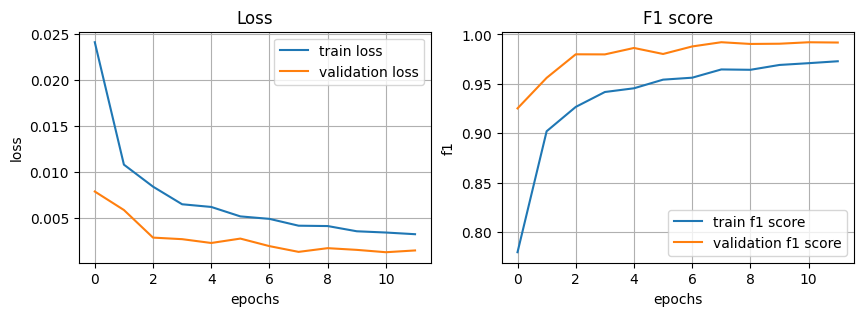

In [31]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].set_title("Loss")
ax[0].plot(np.arange(0, 12), losses["train"], label="train loss")
ax[0].plot(np.arange(0, 12), losses["val"], label="validation loss")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[0].grid()

ax[1].set_title("F1 score")
ax[1].plot(np.arange(0, 12), f1["train"], label="train f1 score")
ax[1].plot(np.arange(0, 12), f1["val"], label="validation f1 score")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("f1")
ax[1].legend()
ax[1].grid()

**Висновок щодо fine-tuning моделі Resnet18**

1. ResNet показала набагато кращий результат, ніж попереня модель Custom CNN. Значення f1 на валідаційній вибірці - **0.991**, loss - **0.001**.
2. 12 епох вистачило для достягнення такої точності, проте в майбутньому варто продовжити навчання, поки не відбудеться явного перенавчання на графіках.
3. Mодель ResNet буде використана для фінального передбачення на тестових даних.

In [33]:
label_encoder = pickle.load(open("label_encoder.pkl", "rb"))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
preds = predict(resnet, test_loader)

preds = label_encoder.inverse_transform(np.argmax(preds, axis=1))
test_filenames = [path.name for path in test_dataset.files]

submit = pd.DataFrame({"Id": test_filenames, "Expected": preds})
submit.to_csv("submission_ResNet18.csv", index=False)
submit.head(4)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
